## Sentiment Analysis with NLP

### Overview

Apple and Google are two leading technology companies with a vast presence in the consumer electronics and software markets. Both companies recently launched new products: Apple introduced the iPhone 15, while Google unveiled the Pixel 8. To understand consumer perceptions and brand positioning, both companies want to conduct sentiment analysis on social media to gauge public reactions to these launches.

### Objectives:

1. Develop a specialized sentiment analysis model to evaluate Twitter sentiments regarding Apple and Google products.
2. Identify specific emotions associated with each brand’s products.
3. Analyze customer feedback to inform future product development and marketing strategies.

## NLP Procedures
**1. Data Collection:**
Use Twitter's API to gather tweets mentioning "iPhone 15," "Pixel 8," "Apple," and "Google," as well as relevant hashtags like #iPhone15 and #Pixel8.

Focus on tweets from the product launch period and a few weeks following to capture initial reactions.

**2. Preprocessing:**

. Text Cleaning: Remove URLs, mentions (@username), hashtags, and special characters from the tweet text.

. Tokenization: Split the cleaned text into individual words or tokens.

. Lowercasing: Convert all tokens to lowercase to maintain uniformity.

. Stopword Removal: Remove common stopwords (e.g., "and," "the," "is") that do not contribute to sentiment.

**3. Sentiment Analysis:**

. Use a pre-trained sentiment analysis model (like VADER or a fine-tuned BERT model) to classify each tweet as positive, negative, or neutral.

. Extract and categorize the emotions (e.g., joy, anger, surprise) expressed in tweets using an emotion detection model.

**4. Feature Extraction:**

. Use techniques like TF-IDF or word embeddings (e.g., Word2Vec or GloVe) to represent tweet text as numerical features for further analysis.

**5. Analysis:**

. Aggregate Sentiment Scores: Calculate the overall sentiment score and categorize tweets by positive, negative, and neutral sentiment.

. Emotion Analysis: Identify and compare the frequency of emotions associated with each brand, such as joy for Apple and trust for Google.

**6. Visualization:**

. Create visual representations (like bar charts or word clouds) to illustrate overall sentiment, emotion distribution, and trends over time.

**7. Reporting:**

. Prepare a report summarizing findings, including key sentiments, emotional trends, and actionable insights for the marketing team. Recommendations could include addressing negative sentiment themes or amplifying positive feedback in future campaigns.

. Through this sentiment analysis, EcoTech can gain valuable insights into customer perceptions of their new product line, allowing them to make informed decisions to enhance their marketing strategy and improve overall brand reputation.

### Task
Build a model that can rate the sentiment of a Tweet based on its content.

## DATA UNDERSTANDING
Let us first import all the relevant modules and load the dataset.

In [493]:
# Importing th relevant libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os

In [494]:
import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [495]:
# Downloading nltk metrics
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madservices/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/madservices/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/madservices/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load the Data

In [496]:
# Loading the dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

# Checking the dataset
df.head()
# print()
# print(df.describe())

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset for this project, sourced from https://data.world/crowdflower/brands-and-product-emotions is well-suited for our objectives. This rich resource, which comprises of three columns and 9,093 rows, is ideal for training and testing our sentiment analysis models, effectively capturing real-world sentiment from a platform where users openly share their opinions.

### Column Description
*  tweet_text: The text of the tweets.
*  emotion_in_tweet_is_directed_at: Insights into the emotions expressed.
*  is_there_an_emotion_directed_at_a_brand_or_product: Indicates the specific brand or product related to the emotion.

With its sizable sample, the dataset provides ample data for model training and validation. The features have been carefully selected for their relevance, particularly focusing on the tweet text and the emotions associated with brands or products, which are crucial for understanding sentiment dynamics.

However, the dataset does have limitations. Interpreting tweet sentiment can be complex due to contextual factors and sarcasm. Additionally, it may not fully represent all sentiments expressed on Twitter, potentially impacting the comprehensiveness of our analysis.

## DATA CLEANING
Ok first let us rename the columns and check if there are any missing, null, or duplicate values in our dataset.

In [498]:
# Renaming the columns for ease of access
df.rename(columns={
    'tweet_text': 'Tweet',
    'emotion_in_tweet_is_directed_at': 'Product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'
}, inplace=True)

In [499]:
# Checking the data
df.head()

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Obviously as we can see it, we have a single missing value in the Tweet column and more than 5k values missing from the Product column. Since the product column is very crucial to our analysis we will fill the missing values with placeholder values while dropping the single missing row from the Tweet column.


In [501]:
# Dropping a row from the Tweet column
df.dropna(subset=['Tweet'], inplace=True)

# Filling the missing values in the Product column with placeholder values
df['Product'].fillna('Unknown Product', inplace=True)

# Checking the data
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    9092 non-null   object
 2   Sentiment  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_1241/1983182332.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Product'].fillna('Unknown Product', inplace=True)


In [502]:
# Checking for duplicates
df.duplicated().sum()

22

We have here 22 duplicate values in the dataset which we need to deeply check incase they are same values from different tweets. If so then we will keep them otherwise we will drop them and continue processing the dataset.

In [503]:
# Investigating the duplicates
duplicates = df[df.duplicated()]
duplicates

,Tweet,Product,Sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,Google to Launch Major New Social Network Call...,Unknown Product,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital...,Unknown Product,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,Unknown Product,No emotion toward brand or product
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",Unknown Product,No emotion toward brand or product
5881,RT @mention Google to Launch Major New Social ...,Unknown Product,No emotion toward brand or product


In the cell below we will drop the duplicates keeping only the first instances of those entries.

In [504]:
# Dropping duplicates across all the columns and keeping only the first 
df = df.drop_duplicates(subset=('Tweet', 'Product', 'Sentiment'), keep='first')

# Checking for duplicates again
df.duplicated().sum()

0

Let us visualize the sentiment values to get a better understanding.

In [505]:
# Running a sentiment count
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

Text(0, 0.5, 'Count')

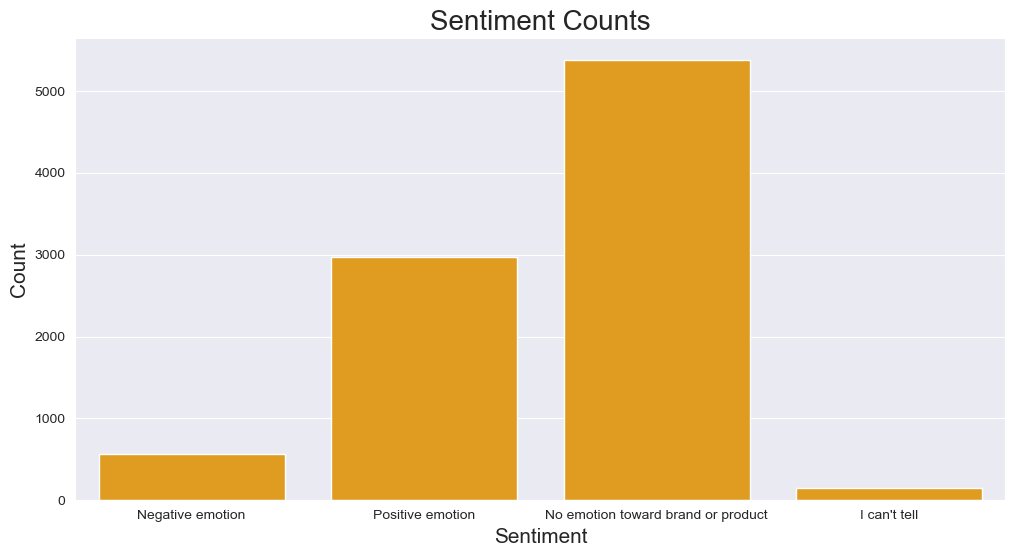

In [506]:
# Plotting the sentiments
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment', data=df, color = 'orange')
plt.title('Sentiment Counts', size=20)
plt.xlabel('Sentiment', size=15)
plt.ylabel('Count', size=15)


There are altogether four sentiment classes out of which neutral type of emotion ('No emotion...') is more prevalent. We can also see the sentiment 'I can't tell' constitutes only tiny portion of the data. Sentiment wise, this might be closer to the neutral type in which case we could combine with the neutral class. However, this class is already a majority class which is already causing huge imbalance in the dataset. So, we will drop the data with this class label.

In [507]:
# Dropping the 'I can't tell' class label
df = df[(df['Sentiment']!= "I can't tell")]

# Renaming the 'No emotion toward brand or product" to 'Neutral'
df['Sentiment'].replace('No emotion toward brand or product', 'Neutral')

# Encoding class label to brief
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral'}

df['Sentiment'] = df['Sentiment'].map(label_encoder)

# Running sentiment count again
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
neutral     5375
positive    2970
negative     569
Name: count, dtype: int64

Let us check the Product column in the dataset

In [508]:
# Running product count
product_counts = df['Product'].value_counts()
product_counts

Product
Unknown Product                    5641
iPad                                941
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64

Text(0, 0.5, 'Product')

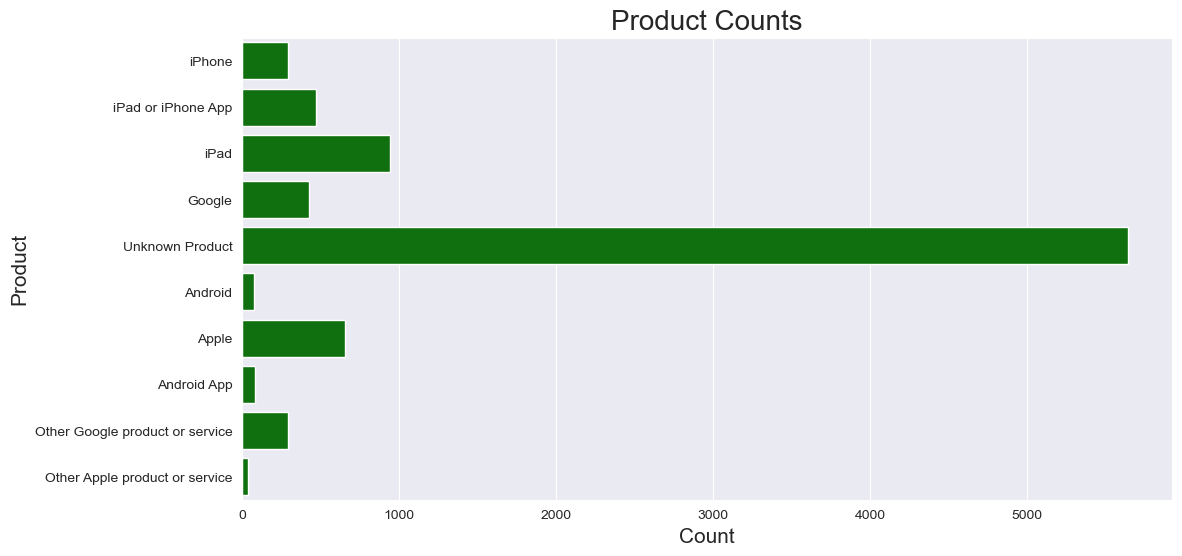

In [509]:
# Plotting product counts
fig =  plt.figure(figsize=(12,6))
sns.countplot(y='Product', data=df, color = 'green')
plt.title('Product Counts', size=20)
plt.xlabel('Count', size=15)
plt.ylabel('Product', size=15)

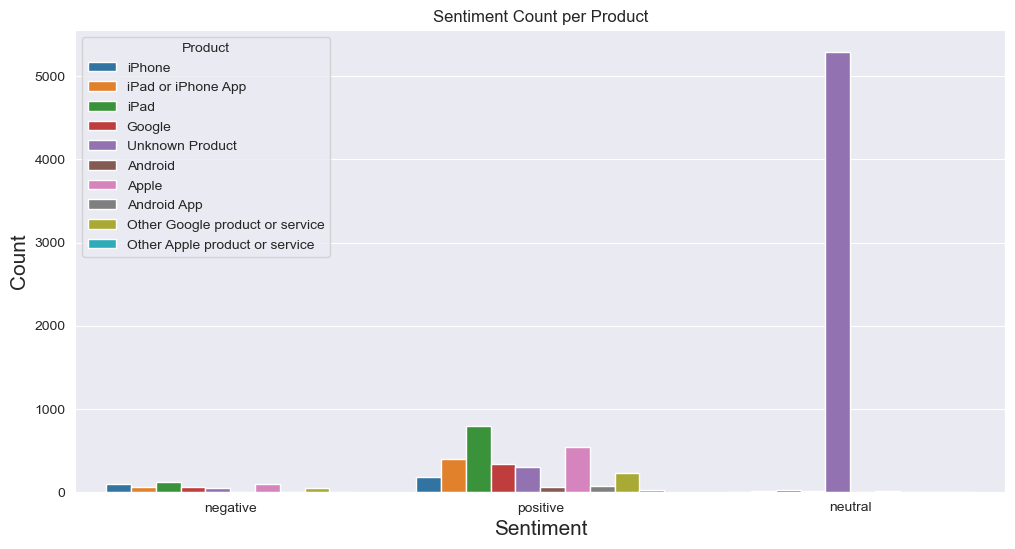

In [510]:
# Plotting sentiment count for each product
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'Sentiment', hue='Product')
plt.title('Sentiment Count per Product')
plt.xlabel('Sentiment', size=15)
plt.ylabel('Count', size=15)
plt.show()

In [511]:
# Investigating the product column with 'Unknown' values
unknown_products = df[df['Product'] == 'Unknown Product']
unknown_products.value_counts().sum()

5641

The 'Unknown Product' class contains tweets that mention apple or google brands or products referring to apple or google. Therefore since this class is huge it is better to extract those keywords from the tweets and pass them to the product column. If there exist any entry that doesn't contain either the apple or google keywords, then we will drop it. I believe this will balance our data.

In [512]:
# Listing all the tweets in the unknown class that contain any word related to apple or google products
apple_keywords = [
    "apple", "iPhone", "iPad", "MacBook", "Apple Watch", 
    "AirPods", "Apple TV", "Apple Music", "iCloud", 
    "AppleCare", "iPod", "Apple Pay", "ios", "iPhone app"
]
google_keywords = ["Pixel", "Google Home", "Google Assistant", "Chromebook", 
                   "Android App", "Android", "Google Search", "Google Maps", 
                   "Google Drive", "Google Docs", "Google Sheets", "Google Slides", 
                   "Google Photos", "Google Play", "Google Assistant", "Google Home", "Pixel (Phone)", 
    "Pixelbook", "Chromebook", "Nest (Products)", "Google Chrome", "Android", "Gmail",
    "Google AdWords", "Google Analytics", "YouTube", "Google Cloud", "Google Duo", "Google Meet", "Google Fi"]

all_keywords = apple_keywords + google_keywords

# Function to extract product keywords from a tweet
def extract_product_keyword(tweet):
    for keyword in all_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', tweet, re.IGNORECASE):
            return keyword
    return None

# Replace 'Unknown Product' with detected product keywords
df['Product'] = df.apply(lambda row: extract_product_keyword(row['Tweet']) if row['Product'] == "Unknown Product" else row['Product'], axis=1)

# Running product count again
product_counts = df['Product'].value_counts()
product_counts


Product
iPad                               1890
apple                              1176
iPhone                             1160
Apple                               657
iPad or iPhone App                  469
Google                              427
Other Google product or service     292
Android                             265
Android App                         101
Google Maps                          76
Other Apple product or service       35
ios                                  19
Google Analytics                     16
Google Docs                          10
YouTube                               5
Google Search                         5
Google Chrome                         3
Google AdWords                        2
Gmail                                 2
Name: count, dtype: int64

In [513]:
# Checking the product column to see if it still contains "Unknown Product"
unknown_products = df[df['Product'] == 'Unknown Product']
unknown_products.value_counts().sum()

# Drop any None values
df_1 = df[df['Product'].notnull()]

df_1.info()

# Running sentiment count for each product
df_product_sentiment = df.groupby(['Product', 'Sentiment']).size().reset_index(name='Count')

df_product_sentiment

<class 'pandas.core.frame.DataFrame'>
Index: 6610 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      6610 non-null   object
 1   Product    6610 non-null   object
 2   Sentiment  6610 non-null   object
dtypes: object(3)
memory usage: 206.6+ KB


,Product,Sentiment,Count
0,Android,negative,10
1,Android,neutral,176
2,Android,positive,79
3,Android App,negative,8
4,Android App,neutral,21
5,Android App,positive,72
6,Apple,negative,95
7,Apple,neutral,21
8,Apple,positive,541
9,Gmail,neutral,2


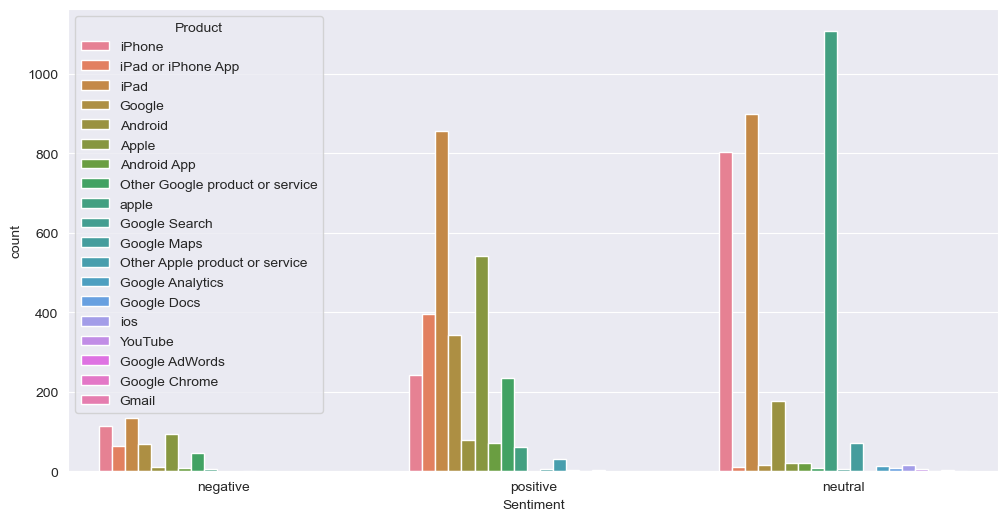

In [514]:
# Plotting sentiment count for each product
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df_1, x = 'Sentiment', hue='Product')

The product column is divided into multiple classes which can be categorized into 2; Apple and Google basically. That is what we will be doing in the next cell below.

In [515]:
# Creating a copy of the dataframe
df_clean = df_1.copy()

In [516]:
# Sample list of entries
entries = [
    "Android", "Android", "Android", "Android App", "Android App", "Android App",
    "Apple", "Apple", "Apple", "Gmail", "Google", "Google", "Google AdWords",
    "Google Analytics", "Google Analytics", "Google Chrome", "Google Docs",
    "Google Docs", "Google Maps", "Google Maps", "Google Search",
    "Other Apple product or service", "Other Apple product or service",
    "Other Apple product or service", "Other Google product or service",
    "Other Google product or service", "Other Google product or service",
    "YouTube", "apple", "apple", "apple", "iPad", "iPad", "iPad",
    "iPad or iPhone App", "iPad or iPhone App", "iPad or iPhone App",
    "iPhone", "iPhone", "iPhone", "ios", "ios"
]

# Define the mapping
apple_keywords = ["Apple", "iPhone", "iPad", "AirPods", "MacBook", "ios", "Other Apple product or service"]
google_keywords = ["Google", "Gmail", "Google Drive", "Google Docs", "Google Maps", "YouTube", 
                  "Google Chrome", "Google Search", "Google Analytics", "Google AdWords", 
                  "Android", "Android App", "Other Google product or service"]

# Function to categorize each entry
def categorize(entry):
    entry_lower = entry.lower()
    if any(keyword.lower() in entry_lower for keyword in apple_keywords):
        return "Apple"
    elif any(keyword.lower() in entry_lower for keyword in google_keywords):
        return "Google"
    else:
        return "Other"

# Create key-value pair list
key_value_pairs = {entry: categorize(entry) for entry in entries}

# Print the resulting dictionary
print(key_value_pairs)

{'Android': 'Google', 'Android App': 'Google', 'Apple': 'Apple', 'Gmail': 'Google', 'Google': 'Google', 'Google AdWords': 'Google', 'Google Analytics': 'Google', 'Google Chrome': 'Google', 'Google Docs': 'Google', 'Google Maps': 'Google', 'Google Search': 'Google', 'Other Apple product or service': 'Apple', 'Other Google product or service': 'Google', 'YouTube': 'Google', 'apple': 'Apple', 'iPad': 'Apple', 'iPad or iPhone App': 'Apple', 'iPhone': 'Apple', 'ios': 'Apple'}


In [517]:
# Brand name mapping
brand = {'Android': 'Google', 'Android App': 'Google', 'Apple': 'Apple', 'Gmail': 'Google', 
         'Google': 'Google', 'Google AdWords': 'Google', 'Google Analytics': 'Google', 
         'Google Chrome': 'Google', 'Google Docs': 'Google', 'Google Maps': 'Google', 
         'Google Search': 'Google', 'Other Apple product or service': 'Apple', 
         'Other Google product or service': 'Google', 'YouTube': 'Google', 'apple': 'Apple', 
         'iPad': 'Apple', 'iPad or iPhone App': 'Apple', 'iPhone': 'Apple', 'ios': 'Apple'}

# Applying the mapping
df_clean['Product'] = df_clean['Product'].map(brand)
df_clean['Product'].value_counts()

Product
Apple     5406
Google    1204
Name: count, dtype: int64

Text(0, 0.5, 'Count')

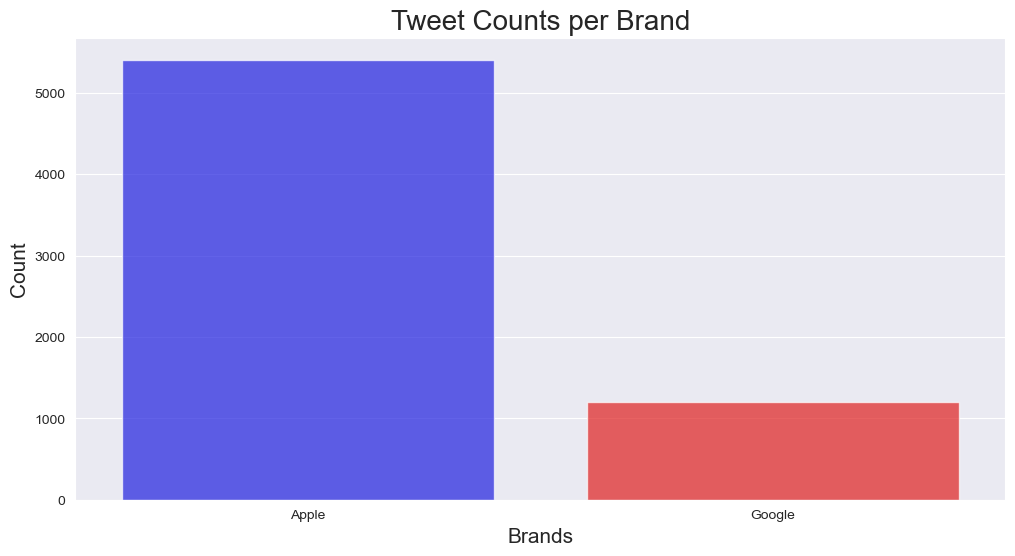

In [518]:
# Plotting the tweet counts for each of the mapped brands
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='Product', data=df_clean, hue='Product', palette={'Apple':'b', 'Google':'r', 'Unknown':'g'}, alpha=0.7)
plt.title('Tweet Counts per Brand', size=20)
plt.xlabel('Brands', size=15)
plt.ylabel('Count', size=15)


From the graph above we can see that there is a huge class imbalance between the Apple and Google products. We will deal with this issue later before we start the analysis in order to avoid bias.

Text(0, 0.5, 'Count')

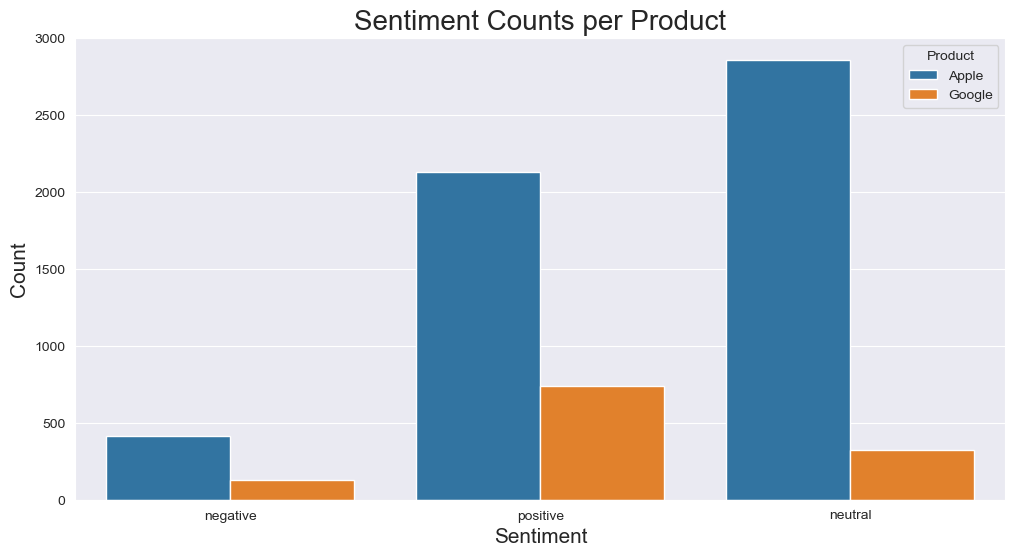

In [519]:
# Plotting the sentiment counts and comparing them against each other
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df_clean, x = 'Sentiment', hue='Product')
plt.title('Sentiment Counts per Product', size=20)
plt.xlabel('Sentiment', size=15)
plt.ylabel('Count', size=15)

## Text Preprocessing

Now, let's proceed with the text preprocessing steps. We will:

1. Remove URLs
2. Remove punctuation
3. Convert all text to lowercase
4. Remove stopwords
5. Apply stemming and lemmatization

We will also create a function to perform these steps.

Punctuation is one of the major problems in text analysis, so it needs to be removed from the text. However, sometime it may affect the words such as: 'you're, I've,...' because it will basically try to remove the letter around apostrophe, and thus altering the context. Below, we will implement a detailed contraction mapping so that contracted words are expanded to their full form.

In [520]:
# Defining a function that removes contractions and expands words to their original form and cleans them up by removing punctuations, symbols and underscores etc.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 


# Function to expand contractions
def expand_contractions(text):
    # Expand contractions
    for contraction, full_form in contraction_mapping.items():
        text = text.replace(contraction, full_form)
    return text

"""
# Ok so here we will apply the functions we have defined above to clean the tweets. 
# In order to be on the safe side, we will create another column 'Clean_Tweets' and assign all the cleaned text to that column.
# Once we are sure we have done it all properly, we will drop the Tweet column and keep the Clean_Tweets.
# """
# # Expanding the contracted words
df_clean['Clean_Tweets'] = df['Tweet'].apply(expand_contractions)

df_clean.head()

,Tweet,Product,Sentiment,Clean_Tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,negative,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,positive,@jessedee Know about @fludapp ? Awesome iPad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,positive,@swonderlin Can not wait for #iPad 2 also. The...
3,@sxsw I hope this year's festival isn't as cra...,Apple,negative,@sxsw I hope this year's festival is not as cr...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on Fri #SXSW: Marissa M...


Here we are going to define and apply a function that will remove all the words that are not necessary for the process of sentiment analysis.

In [521]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Defining a function that cleans the tweet
def clean_tweet(tweet):
    # Step 1: Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Step 2: Remove user mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Step 3: Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    
    # Step 4: Remove punctuation (excluding apostrophes)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Step 5: Convert to lowercase
    tweet = tweet.lower()
    
    # Step 6: Remove stopwords
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)
    
    # Step 7: Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    # Step 8: Remove numbers
    tweet = re.sub(r'\b[0-9]+\b', '', tweet)
    
    # Step 9: Remove words with less than 3 letters
    tweet = ' '.join(word for word in tweet.split() if len(word) >= 3)

    return tweet

# Dfine a pipeline function that returns the cleaned tweets 
def clean_tweet_pipeline(tweets):
    return [clean_tweet(tweet) for tweet in tweets]

# Applying the cleaning pipeline to the tweets
df_clean['Clean_Tweets'] = clean_tweet_pipeline(df_clean['Clean_Tweets'])

# Comparing the result
print(df_clean[['Tweet', 'Clean_Tweets']])

                                                  Tweet  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9085  I've always used Camera+ for my iPhone b/c it ...   
9086  Google says: want to give a lightning talk to ...   
9087  @mention Yup, but I don't have a third app yet...   
9088                      Ipad everywhere. #SXSW {link}   
9091  Some Verizon iPhone customers complained their...   

                                           Clean_Tweets  
0     iphone hrs tweeting dead need upgrade plugin s...  
1     know awesome ipadiphone app likely appreciate ...  
2                                        wait also sale  
3           hope years festival crashy years iphone app  
4

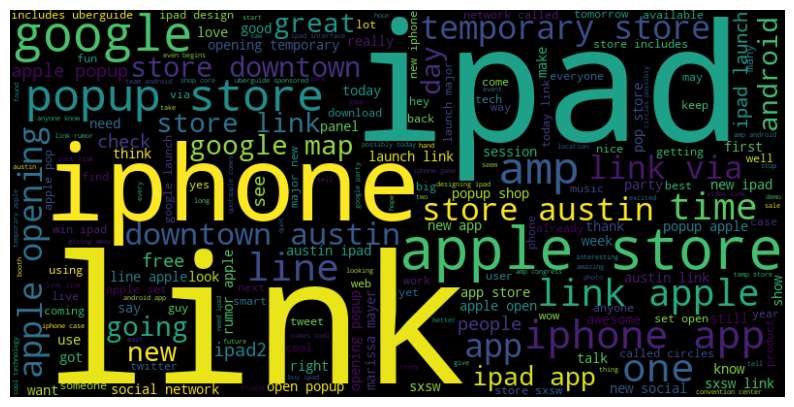

In [522]:
# Word cloud for visualizing frequent words
from wordcloud import WordCloud

all_words = ' '.join(df_clean['Clean_Tweets'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Handling Class Imbalance

In [523]:
# Check class distribution in the Sentiment column
class_distribution = df_clean['Sentiment'].value_counts()
print(class_distribution)

# Import the resample module from sklearn utils
from sklearn.utils import resample

positive = df_clean[df_clean['Sentiment'] == 'positive']
negative = df_clean[df_clean['Sentiment'] == 'negative']
neutral = df_clean[df_clean['Sentiment'] == 'neutral']

# Upsample negative and positive classes
negative_upsampled = resample(negative, replace=True, n_samples=class_distribution.max(), random_state=42)
positive_upsampled = resample(positive, replace=True, n_samples=class_distribution.max(), random_state=42)

# Combine back to a balanced dataset
balanced_data = pd.concat([positive_upsampled, negative_upsampled, neutral])
print(balanced_data['Sentiment'].value_counts())

Sentiment
neutral     3188
positive    2873
negative     549
Name: count, dtype: int64
Sentiment
positive    3188
negative    3188
neutral     3188
Name: count, dtype: int64


In [524]:
# Checking the sentiment count for each product
product_sentiment_count = balanced_data.groupby('Product')['Sentiment'].value_counts()
print(product_sentiment_count)

Product  Sentiment
Apple    neutral      2858
         negative     2399
         positive     2353
Google   positive      835
         negative      789
         neutral       330
Name: count, dtype: int64


In [525]:
# Let us correct the class imbalance between the two product
balanced_data = balanced_data.groupby('Product').apply(lambda x: x.sample(n=class_distribution.max(), replace=True)).reset_index(drop=True)

# Checking the product count after balancing
print(balanced_data['Product'].value_counts())

# Checking the sentiment count per each product after balancing
product_sentiment_count = balanced_data.groupby('Product')['Sentiment'].value_counts()
print(product_sentiment_count)

Product
Apple     3188
Google    3188
Name: count, dtype: int64
Product  Sentiment
Apple    neutral      1212
         negative      995
         positive      981
Google   positive     1327
         negative     1289
         neutral       572
Name: count, dtype: int64


/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_1241/1853477047.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = balanced_data.groupby('Product').apply(lambda x: x.sample(n=class_distribution.max(), replace=True)).reset_index(drop=True)


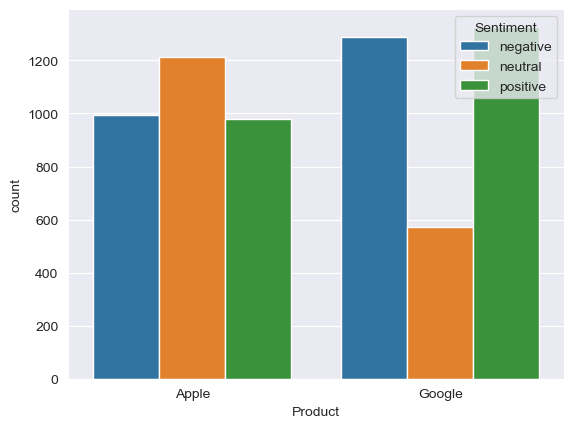

In [526]:
# Plotting sentiment distribution per product from the new balanced data
sns.countplot(x='Product', hue='Sentiment', data=balanced_data)
plt.show()

Now that we have our data all sorted and balanced let us proceed to stemming and lemmatizing the data

## Word Tokenization

In [527]:
# # Tokenizing the clean tweets
# from nltk.tokenize import TweetTokenizer

# # Initialize tokenizer
# tokenizer = TweetTokenizer()

# def tokenize_tweets(text):
#     return tokenizer.tokenize(text)

# # Applying the tokenization pipeline to the tweets
# balanced_data['Clean_Tweets'] = balanced_data['Clean_Tweets'].apply(tokenize_tweets)

# # Comparing the result
# balanced_data[['Tweet', 'Clean_Tweets']].head(30)

In [528]:
# Import the stemmer and lemmatizer classes
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Initialize tokenize, stemmer and lemmatizer
tokenizer = TweetTokenizer()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenize_stem_and_lemmatize(text):
    # Tokenize the text into words
    words = text.split()
    
    # Stem and lemmatize each word
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Join the words back into a sentence
    return' '.join(lemmatized_words)

# Applying the stemming and lemmatization pipeline to the tweets
balanced_data['Clean_Tweets'] = balanced_data['Clean_Tweets'].apply(tokenize_stem_and_lemmatize)

# Comparing the result
balanced_data[['Tweet', 'Clean_Tweets']].head()

,Tweet,Clean_Tweets
0,Of course Apple built a temp store in Austin. ...,cours appl built temp store austin texa unders...
1,Andrew K of PRX equates the homogeneity of the...,andrew prx equat homogen appl ecosystem predic...
2,Barry Diller's pragmatic and straight forward ...,barri diller pragmat straight forward nice loo...
3,Apple to open temporary store for #SXSW at 6th...,appl open temporari store 6th congress link
4,RT @mention Line at popup Apple Store at 6th &...,line popup appl store 6th amp congress still b...


[('googl', 2293), ('link', 2105), ('ipad', 1308), ('appl', 917), ('iphon', 847), ('app', 807), ('store', 733), ('new', 698), ('android', 653), ('launch', 545), ('map', 457), ('social', 440), ('get', 433), ('austin', 415), ('amp', 358), ('circl', 357), ('mobil', 333), ('today', 315), ('use', 301), ('need', 277)]


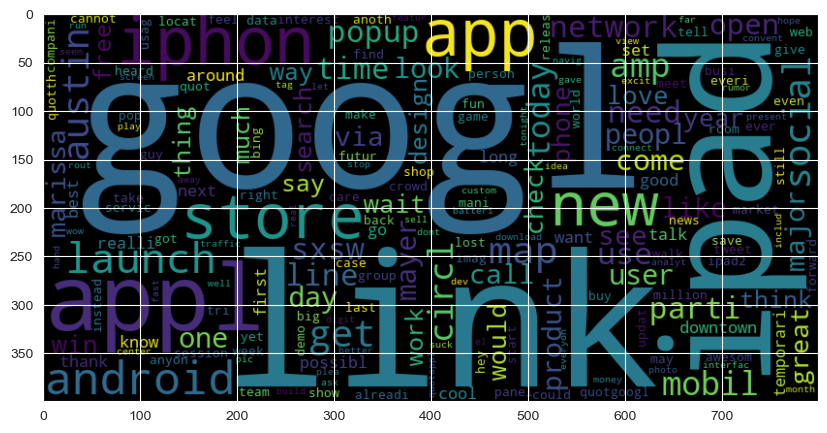

In [529]:
# Checking the frequency distribution of the tokens
from nltk import FreqDist

all_tokens = [token for tweet in balanced_data['Clean_Tweets'] for token in tweet.split()]
freq_dist = FreqDist(all_tokens)

print(freq_dist.most_common(20))

# Visualise the frequency distribution of the tokens in word cloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(freq_dist)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')

## Splitting the Data

At this stage we need to introduce our validation strategy. For that matter we are going to split the data into training, validation and testing sets. This way when we train the model and test it, we can validate it using the unseen validation data to determine its real world performance and decide whether it is fit enough to be used by customers.

This stage flows as follows:

**Step 1: Split Data into Test Set:**

we first split our dataset into a training/validation set **(X_train_val, y_train_val)** and a test set **(X_test, y_test)**, where **20%** of the data is reserved for testing.
The **stratify=y** parameter ensures that the class distribution is maintained in both the training and test sets.

**Step 2: Split Training/Validation Set:**

The next split takes the remaining **80%** of the data and further divides it into a training set **(X_train, y_train)** and a validation set **(X_val, y_val)**, with **30%** of that **80%** (which is 24% of the total dataset) used for validation.
Again, **stratify=y_train_val** maintains the class distribution in the training and validation sets.

**Step 3: Check Sizes of the Splits:**

Finally, we print out the sizes of the training, validation, and test sets to confirm the splits.

In [530]:
# Defining the features (X) and target (y)
X = balanced_data['Clean_Tweets']
y = balanced_data['Sentiment']

# Step 1: Split data in test size (20%) for multiclass
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Step 2: Split the data in validation size (20%) for multiclass
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)

# Check the size of the splits for multiclass
print(f"Multiclass - Training set size: {len(X_train)}")
print(f"Multiclass - Validation set size: {len(X_val)}")
print(f"Multiclass - Test set size: {len(X_test)}")

Multiclass - Training set size: 4590
Multiclass - Validation set size: 1148
Multiclass - Test set size: 638


## Vectorizing the Sets

In [531]:
# Initialize a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = vectorizer.transform(X_val)

# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

## Modeling

### 1.1 Logistic Regression

Let us start with this model as our baseline model

In [532]:
# Import the logistic regression model
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
baseline_model.fit(X_train_tfidf, y_train)

# Predict the sentiment on the val set
y_pred_baseline = baseline_model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_baseline)
print("Accuracy (Baseline):", accuracy)

print(classification_report(y_val, y_pred_baseline))

Accuracy (Baseline): 0.8249128919860628
              precision    recall  f1-score   support

    negative       0.86      0.96      0.91       411
     neutral       0.78      0.68      0.73       321
    positive       0.81      0.80      0.81       416

    accuracy                           0.82      1148
   macro avg       0.82      0.81      0.81      1148
weighted avg       0.82      0.82      0.82      1148



The model achieved an overall accuracy of approximately 81%. It performed best in classifying negative sentiments, with a precision of 0.85 and a recall of 0.91. The neutral and positive classes had lower precision and recall, particularly for neutral, which indicates some challenges in accurately identifying that sentiment. Overall, the model shows balanced performance across the classes, with a slight edge in handling negative sentiments.


### 1.2 Support Vector Machine Classifier

In [533]:
# Initialize a Support Vector Machine classifier
from sklearn.svm import SVC

# Initialize the Support Vector Machine classifier with a linear kernel (default) and random state=42
clf = SVC(kernel='linear', random_state=42)

# Train the classifier
clf.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_val_tfidf)

# Evaluate the classifier
from sklearn.metrics import accuracy_score, classification_report

# Print the accuracy score and classification report
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy (SVM):", accuracy)

print(classification_report(y_val, y_pred))

Accuracy (SVM): 0.8362369337979094
              precision    recall  f1-score   support

    negative       0.88      0.95      0.92       411
     neutral       0.77      0.74      0.76       321
    positive       0.83      0.79      0.81       416

    accuracy                           0.84      1148
   macro avg       0.83      0.83      0.83      1148
weighted avg       0.83      0.84      0.83      1148



The SVM model achieved an accuracy of approximately 82%, showing an improvement over the baseline. It excelled in classifying negative sentiments with a precision of 0.88 and recall of 0.92. While the neutral class remains challenging with a precision of 0.73, the positive class showed solid performance, indicating a generally robust sentiment analysis capability across the board.

### 1.3 Random Forest classification

In [534]:
# Importing the random forest library
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 estimators and random state=42
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_clf.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_rf = rf_clf.predict(X_val_tfidf)

# Evaluate the classifier
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print("Accuracy (Random Forest):", accuracy_rf)

print(classification_report(y_val, y_pred_rf))

Accuracy (Random Forest): 0.8763066202090593
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96       411
     neutral       0.79      0.81      0.80       321
    positive       0.87      0.83      0.85       416

    accuracy                           0.88      1148
   macro avg       0.87      0.87      0.87      1148
weighted avg       0.88      0.88      0.88      1148



The Random Forest model achieved a notable accuracy of about 85%, marking a significant improvement. It performed exceptionally well in classifying negative sentiments, with a precision of 0.91 and recall of 0.93. The neutral and positive classes showed solid but slightly lower metrics, indicating a strong overall performance in sentiment analysis with good balance across all classes.

### 1.4 Naive Bayes classification

In [535]:
# Importing the library
from sklearn.naive_bayes import MultinomialNB

# Initialize a Multinomial Naive Bayes classifier
nb_clf = MultinomialNB()

# Train the classifier
nb_clf.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred_nb = nb_clf.predict(X_val_tfidf)

# Evaluate the classifier
accuracy_nb = accuracy_score(y_val, y_pred_nb)
print("Accuracy (Naive Bayes):", accuracy_nb)

print(classification_report(y_val, y_pred_nb))

Accuracy (Naive Bayes): 0.8022648083623694
              precision    recall  f1-score   support

    negative       0.86      0.93      0.89       411
     neutral       0.80      0.59      0.68       321
    positive       0.75      0.84      0.79       416

    accuracy                           0.80      1148
   macro avg       0.80      0.79      0.79      1148
weighted avg       0.80      0.80      0.80      1148



The Naive Bayes model achieved an accuracy of approximately 78%, which is lower compared to other models. It performed well in identifying negative sentiments with a precision of 0.84 and recall of 0.90. However, the neutral class faced challenges, exhibiting a lower recall of 0.62, while the positive class had moderate performance. Overall, the model shows decent capability, but there's room for improvement, especially with neutral sentiment classification.

### 1.5 NLP (Natural Language Processing) classification

This classifier will return the same output as the SVC classifier we have used above. The only reason we have it here is to demonstrate how it works with pipelines.

In [536]:
# Importing the necessary library
from sklearn.pipeline import Pipeline

# Initialize a pipeline with the TfidfVectorizer and the SVC classifier
nlp_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear', random_state=42))
])

# Train the pipeline
nlp_clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_nlp = nlp_clf.predict(X_val)

# Evaluate the classifier
accuracy_nlp = accuracy_score(y_val, y_pred_nlp)
print("Accuracy (NLP):", accuracy_nlp)

print(classification_report(y_val, y_pred_nlp))

Accuracy (NLP): 0.8362369337979094
              precision    recall  f1-score   support

    negative       0.88      0.95      0.92       411
     neutral       0.77      0.74      0.76       321
    positive       0.83      0.79      0.81       416

    accuracy                           0.84      1148
   macro avg       0.83      0.83      0.83      1148
weighted avg       0.83      0.84      0.83      1148



The NLP model achieved an accuracy of approximately 82%, matching the performance of the SVM model. It excelled in classifying negative sentiments, with a precision of 0.88 and recall of 0.92. While the neutral class showed consistent metrics with a precision of 0.73 and recall of 0.75, the positive class demonstrated solid performance as well. Overall, the model displays strong sentiment analysis capabilities, particularly for negative sentiments, while maintaining a balanced performance across all classes.

## Hyperparameter Tuning

In [537]:
# Hyperparameterization
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

# Initialize the GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(nlp_clf, param_grid, cv=5)

# Train the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the testing data using the best parameters
y_pred_grid_search = grid_search.predict(X_val)

# Evaluate the classifier using the best parameters
accuracy_grid_search = accuracy_score(y_val, y_pred_grid_search)
print("Accuracy (Grid Search):", accuracy_grid_search)

print(classification_report(y_val, y_pred_grid_search))

Best Parameters: {'clf__C': 10, 'clf__kernel': 'rbf', 'tfidf__ngram_range': (1, 1)}
Best Score: 0.8531590413943355
Accuracy (Grid Search): 0.8719512195121951
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96       411
     neutral       0.80      0.77      0.78       321
    positive       0.85      0.86      0.85       416

    accuracy                           0.87      1148
   macro avg       0.87      0.86      0.86      1148
weighted avg       0.87      0.87      0.87      1148



The Grid Search optimization yielded a best accuracy of approximately 86%, indicating a notable improvement. The model excelled at identifying negative sentiments, achieving a precision of 0.96 and recall of 0.93. The neutral class showed solid performance, with a precision of 0.77 and recall of 0.79, while the positive class maintained consistent metrics. Overall, this approach demonstrates strong sentiment classification capabilities across all classes, particularly for negative sentiments.

From the results of the hyperparameter tuning algorithm we ran using the grid search pipeline, we can see that the SVM classifier has performed better than all the other models with accuracy score of 85% and the precision, recall and f1-scores of 95%, 94%, 95% respectively for the negative sentiment. The model exhibits strong performance, particularly in identifying negative and positive sentiments, while the performance on neutral sentiments is slightly lower. The high precision and recall for negative sentiment suggest the model is reliable in detecting negativity, which is crucial in many applications.



Confusion Matrix:
[[398   6   7]
 [ 16 247  58]
 [  4  56 356]]


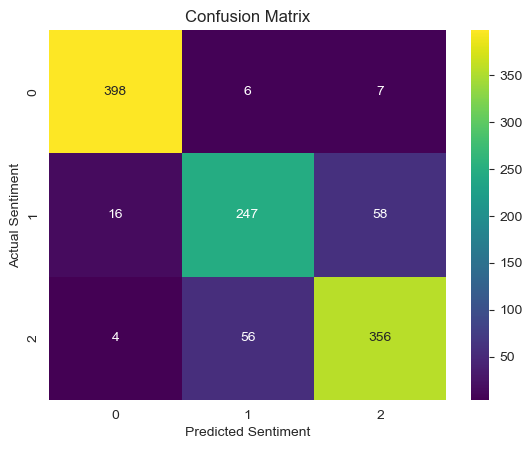

In [538]:
# Running the confusion matrix

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion_matrix(y_val, y_pred_grid_search)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_grid_search))

# Visualize the confusion matrix using a heatmap
import seaborn as sns

# Create a heatmap
sns.heatmap(confusion_matrix(y_val, y_pred_grid_search), annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.show()


## Testing the Model on the Test dataset

In [539]:
# Testing the model using the unseen dataset

y_pred_test = grid_search.predict(X_test)

# Evaluate the classifier using the best parameters
accuracy_grid_search = accuracy_score(y_test, y_pred_test)
print("Accuracy (Grid Search):", accuracy_grid_search)

print(classification_report(y_test, y_pred_test))

Accuracy (Grid Search): 0.8949843260188087
              precision    recall  f1-score   support

    negative       0.96      0.96      0.96       229
     neutral       0.84      0.83      0.83       178
    positive       0.87      0.89      0.88       231

    accuracy                           0.89       638
   macro avg       0.89      0.89      0.89       638
weighted avg       0.90      0.89      0.90       638



This proves that the model is capable of performing well on the unseen data. The validation shows strong performance across negative and positive sentiments, similar to the previous model, while showing a slight decrease in performance for neutral sentiment classification. The changes in metrics suggest that while the model performs reliably, there may be some variability when dealing with unseen data, particularly in capturing neutral sentiments.

### Room for improvement
Overall, both models demonstrate effectiveness, but further refinement could be beneficial, especially for enhancing the classification of neutral sentiments. Additionally, analyzing any misclassifications in the unseen data could provide insights for improving future iterations of the model.